In [1]:
import pandas as pd
import numpy as np
import joblib as jb
#import tifffile
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_division
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [2]:
df = jb.load('../data/generated/df_newimages_bands_downside.pkl.z')

In [3]:
df.describe()

,x,y,z,b0,b1,b2,b3,b4,b5,b6,b7,b2b4,b3b4,ndwi15,ndwi24,ndwi53
count,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000,19697.000000
mean,1137.377570,646.869371,7.149796,0.122860,0.093295,0.072509,0.047179,0.040728,0.026751,0.025194,0.020427,1.162114,1.042204,0.556660,0.285827,-0.276635
std,472.210011,407.379383,4.519822,0.003302,0.004482,0.005488,0.007070,0.007772,0.004554,0.004870,0.004048,0.044290,0.020664,0.046374,0.064978,0.040163
min,226.000000,1.000000,0.640000,0.115700,0.080500,0.054800,0.030900,0.026800,0.018900,0.014400,0.013400,1.014565,0.930641,0.110121,0.030970,-0.408163
25%,775.000000,328.000000,3.442308,0.120300,0.090000,0.068600,0.041900,0.035000,0.023900,0.022000,0.017900,1.135662,1.035149,0.544000,0.251376,-0.304487
50%,1026.000000,601.000000,6.179412,0.122900,0.093500,0.073000,0.046100,0.039100,0.025800,0.024000,0.019600,1.166537,1.046836,0.568394,0.295956,-0.283912
75%,1532.000000,946.000000,9.742000,0.125300,0.096400,0.076100,0.051400,0.044800,0.028300,0.026900,0.021900,1.193937,1.055593,0.585538,0.332215,-0.257942
max,2296.000000,1638.000000,25.763448,0.135600,0.113700,0.095200,0.080800,0.075300,0.069900,0.076200,0.059000,1.283361,1.095247,0.644794,0.435737,0.193851


<Figure size 864x432 with 0 Axes>

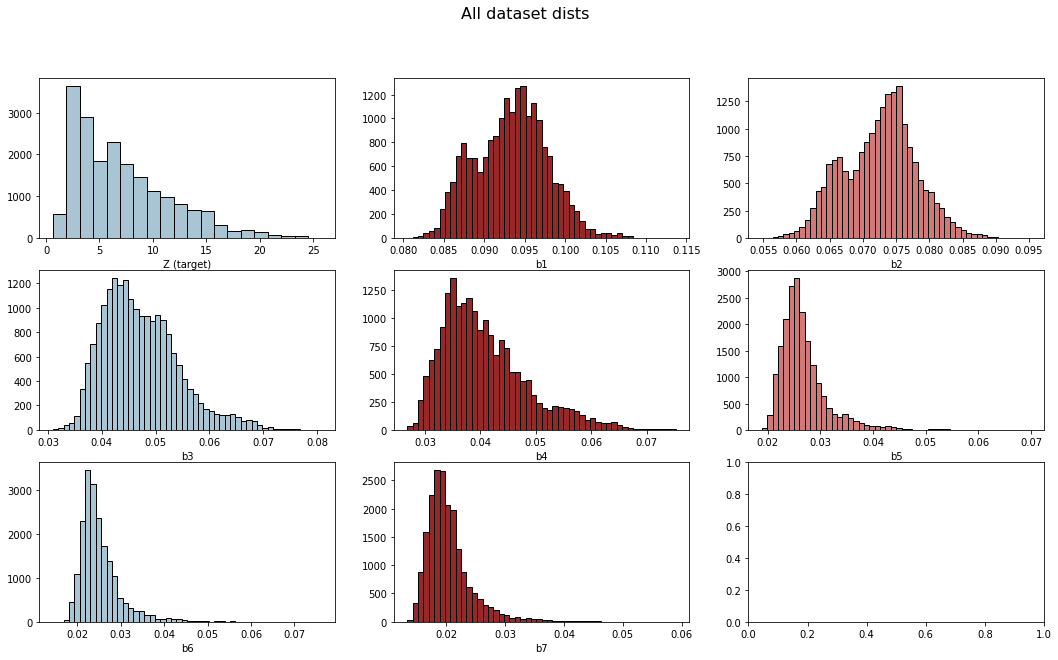

In [31]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(df.z, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(df.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(df.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(df.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(df.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(df.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(df.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(df.b7, bins=50, color='#952828', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
#_ = axs[2][2].hist(df.b8, bins=20, color='#A9C5D3', edgecolor='black')
fig.suptitle('All dataset dists', fontsize=16)
fig.savefig('charts/alldata.jpg')

In [7]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(['x', 'y', 'z'], axis=1), df.z, test_size=0.3, random_state=42)

<Figure size 864x432 with 0 Axes>

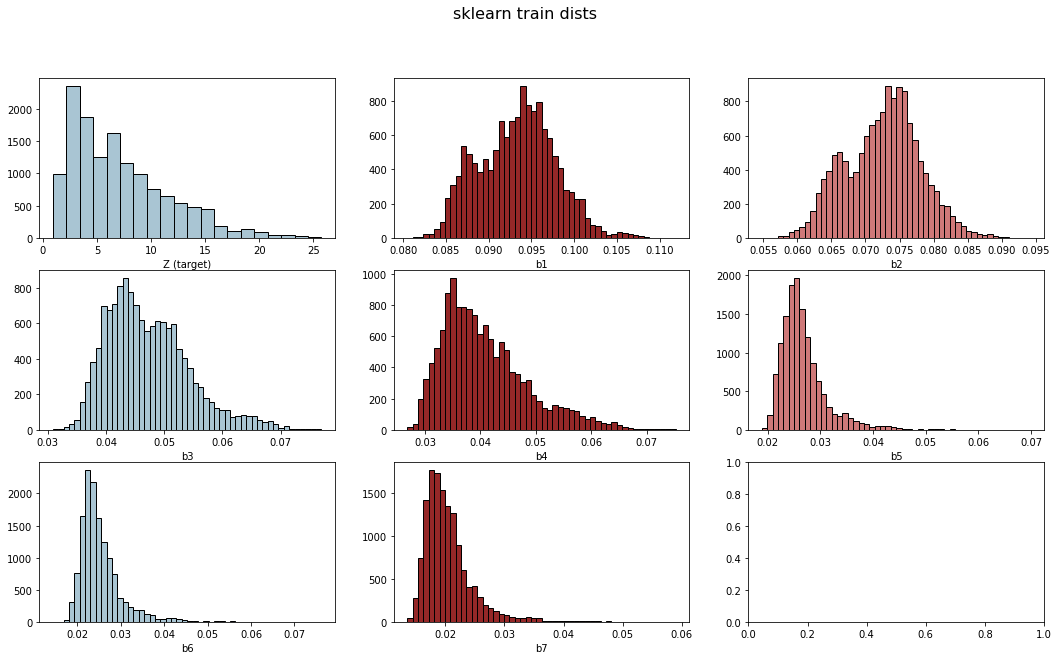

In [32]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(y_train, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(X_train.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(X_train.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(X_train.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(X_train.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(X_train.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(X_train.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(X_train.b7, bins=50, color='#952828', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
#_ = axs[2][2].hist(df.b8, bins=20, color='#A9C5D3', edgecolor='black')
fig.suptitle('sklearn train dists', fontsize=16)
fig.savefig('charts/sktraindata.jpg')

<Figure size 864x432 with 0 Axes>

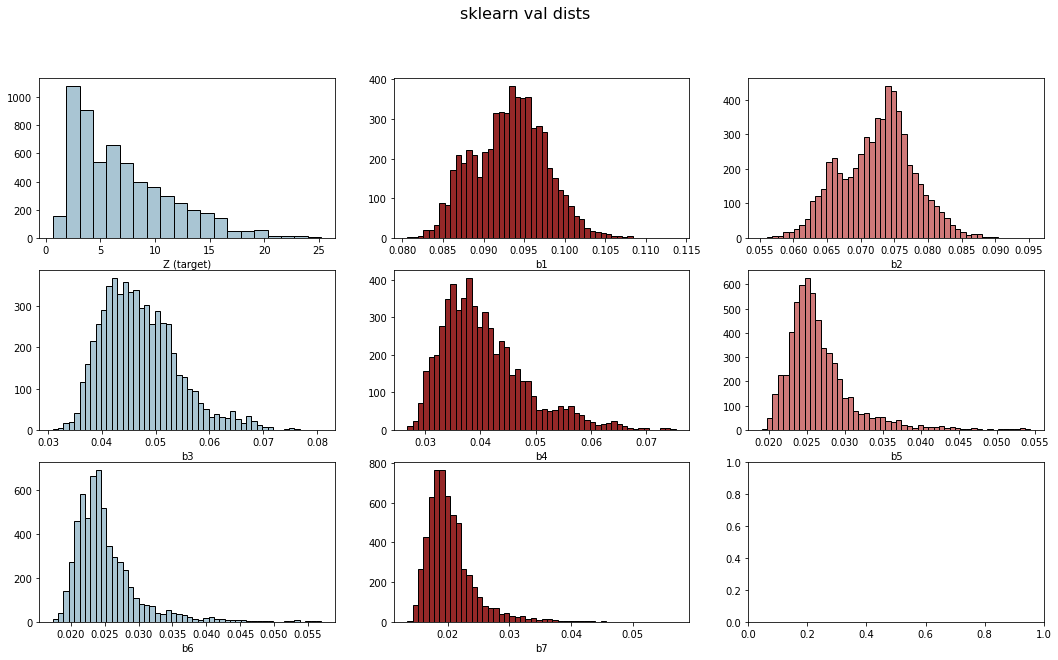

In [33]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(y_val, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(X_val.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(X_val.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(X_val.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(X_val.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(X_val.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(X_val.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(X_val.b7, bins=50, color='#952828', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
#_ = axs[2][2].hist(df.b8, bins=20, color='#A9C5D3', edgecolor='black')
fig.suptitle('sklearn val dists', fontsize=16)
fig.savefig('charts/skvaldata.jpg')

In [13]:
df_half = df.copy()

In [43]:
th = 800
features_train_half = df_half[df_half.x > th].drop(['x', 'y', 'z'], axis=1)
target_train_half = df_half[df_half.x > th].z

features_val_half = df_half[df_half.x <= th].drop(['x', 'y', 'z'], axis=1)
target_val_half = df_half[df_half.x <= th].z

In [44]:
len(features_val_half), len(features_train_half)

(5431, 14266)

<Figure size 864x432 with 0 Axes>

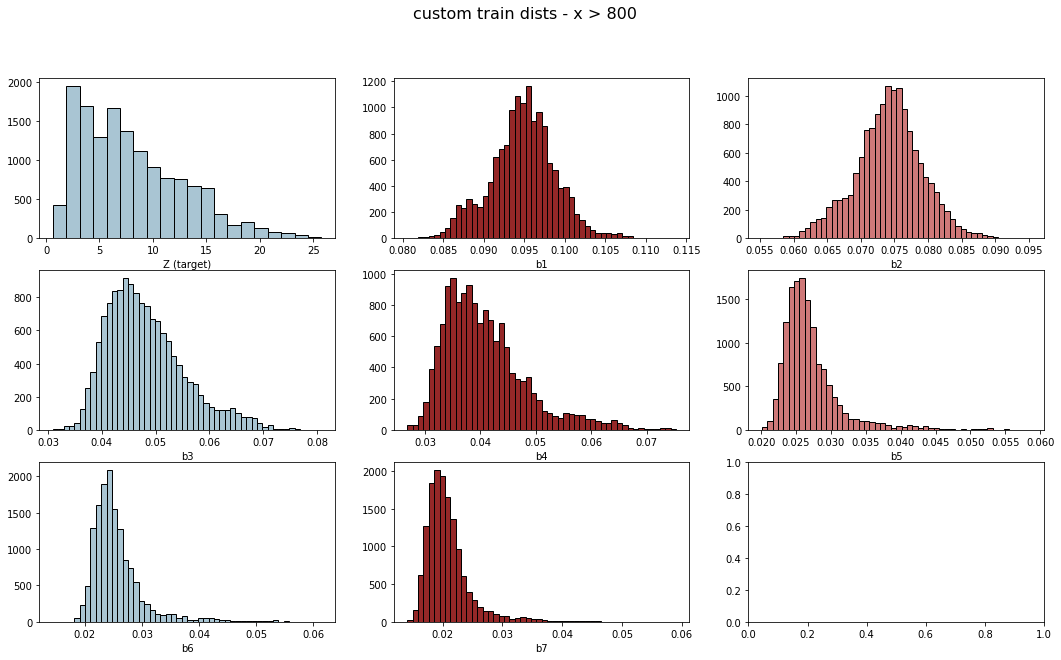

In [48]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(target_train_half, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(features_train_half.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(features_train_half.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(features_train_half.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(features_train_half.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(features_train_half.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(features_train_half.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(features_train_half.b7, bins=50, color='#952828', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
#_ = axs[2][2].hist(df.b8, bins=20, color='#A9C5D3', edgecolor='black')
fig.suptitle(f'custom train dists - x > {th}', fontsize=16)
fig.savefig('charts/custom_traindata.jpg')

<Figure size 864x432 with 0 Axes>

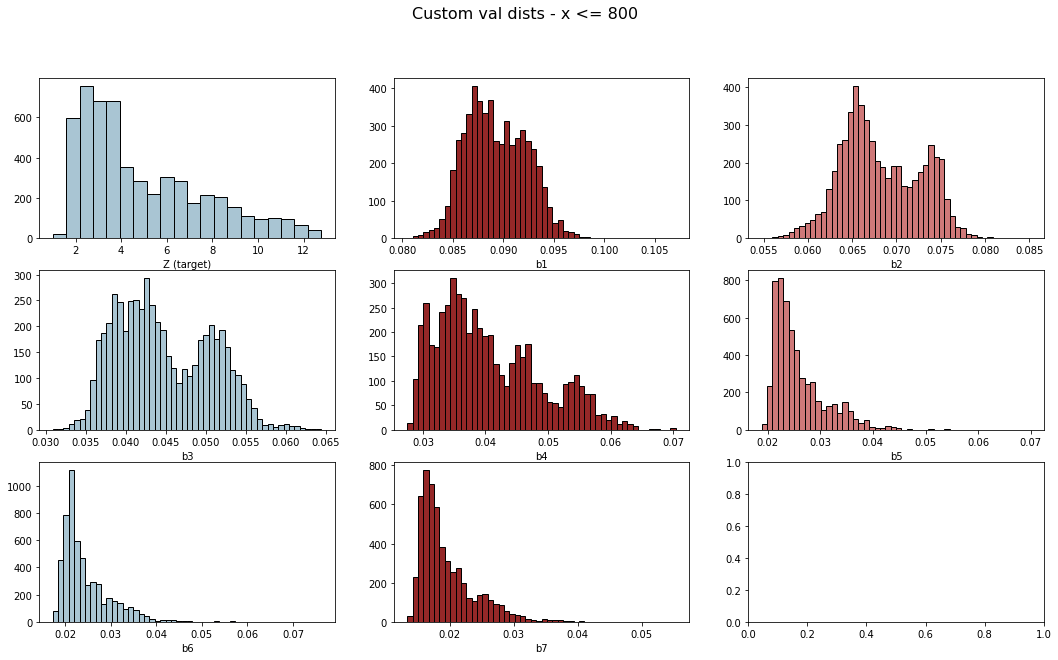

In [47]:
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18, 10))
_ = axs[0][0].hist(target_val_half, bins=20, color='#A9C5D3', edgecolor='black')
_ = axs[0][1].hist(features_val_half.b1, bins=50, color='#952828', edgecolor='black')
_ = axs[0][2].hist(features_val_half.b2, bins=50, color='#cf7979', edgecolor='black')
_ = axs[1][0].hist(features_val_half.b3, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[1][1].hist(features_val_half.b4, bins=50, color='#952828', edgecolor='black')
_ = axs[1][2].hist(features_val_half.b5, bins=50, color='#cf7979', edgecolor='black')
_ = axs[2][0].hist(features_val_half.b6, bins=50, color='#A9C5D3', edgecolor='black')
_ = axs[2][1].hist(features_val_half.b7, bins=50, color='#952828', edgecolor='black')
axs[0][0].set_xlabel('Z (target)')
axs[0][1].set_xlabel('b1')
axs[0][2].set_xlabel('b2')
axs[1][0].set_xlabel('b3')
axs[1][1].set_xlabel('b4')
axs[1][2].set_xlabel('b5')
axs[2][0].set_xlabel('b6')
axs[2][1].set_xlabel('b7')
fig.suptitle(f'Custom val dists - x <= {th}', fontsize=16)
fig.savefig('charts/custom_savefig.jpg')

In [6]:
df.head(1)

,x,y,z,b0,b1,b2,b3,b4,b5,b6,b7,b2b4,b3b4,ndwi15,ndwi24,ndwi53
0,226,1010,2.117692,0.1225,0.0919,0.0721,0.0516,0.0528,0.0337,0.0311,0.0256,1.078543,0.994204,0.463376,0.154524,-0.209848


/home/vinicius/Área de Trabalho/Environments/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vinicius/Área de Trabalho/Environments/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vinicius/Área de Trabalho/Environments/jupyter/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments

<Figure size 864x432 with 0 Axes>

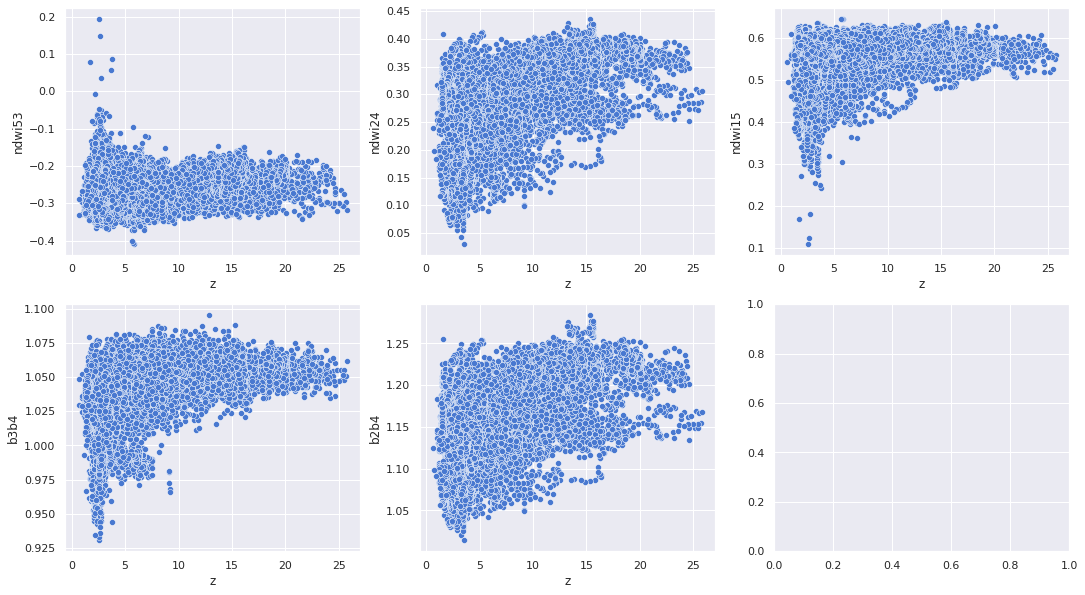

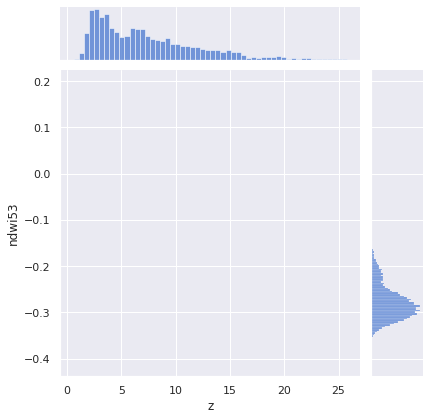

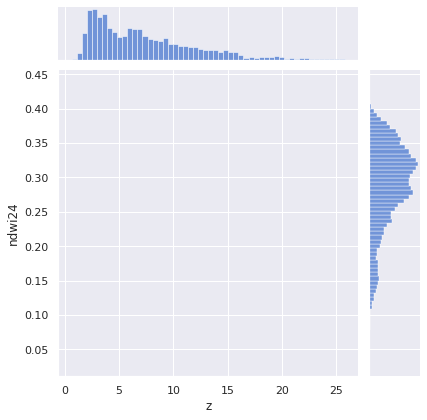

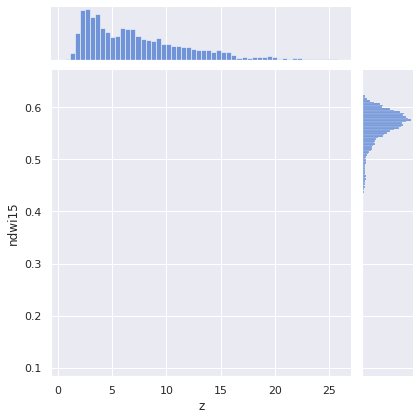

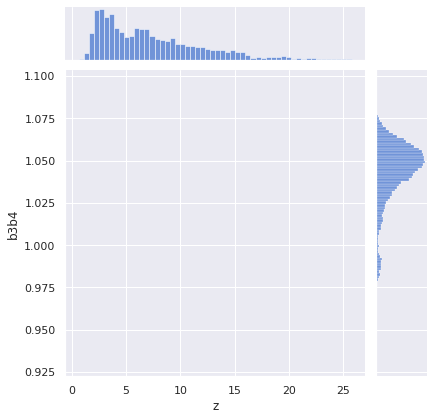

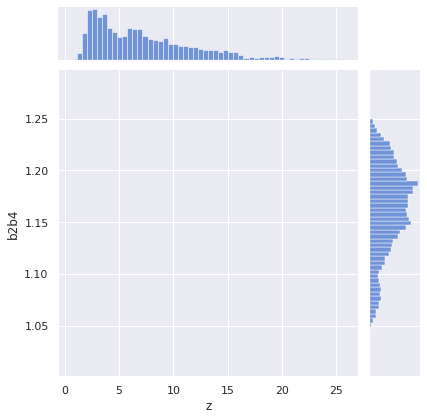

In [134]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

_ = sns.jointplot(df.z, df.ndwi53, ax=axs[0,0])
_ = sns.jointplot(df.z, df.ndwi24, ax=axs[0, 1])
_ =sns.jointplot(df.z, df.ndwi15, ax=axs[0, 2])
_ = sns.jointplot(df.z, df.b3b4, ax=axs[1, 0])
_ = sns.jointplot(df.z, df.b2b4, ax=axs[1, 1])


In [5]:
# Check for skewness on data
skew_df = pd.DataFrame()

In [6]:
for column in df:
    skew_df[f'skew_{column}'] = pd.Series(df[column].skew())

In [7]:
skew_df

,skew_x,skew_y,skew_z,skew_b0,skew_b1,skew_b2,skew_b3,skew_b4,skew_b5,skew_b6,skew_b7,skew_b2b4,skew_b3b4,skew_ndwi15,skew_ndwi24,skew_ndwi53
0,0.34944,0.40148,1.02246,0.054585,0.101097,-0.031658,0.816591,1.048598,2.108079,2.241614,2.040255,-0.446293,-1.44767,-2.003197,-0.749654,1.216095


In [8]:
# Log transformation for all variables
transform = preprocessing.FunctionTransformer(np.sqrt, validate=True)

In [9]:
log_bands = pd.DataFrame(transform.transform(df.drop(['z', 'ndwi15', 'ndwi24', 'ndwi53', 'b3b4', 'b2b4', 'x', 'y'], axis=1)))
log_bands.columns = df.drop(['z', 'ndwi15', 'ndwi24', 'ndwi53', 'b3b4', 'b2b4', 'x', 'y'], axis=1).columns

In [10]:
log_bands.head()

,b0,b1,b2,b3,b4,b5,b6,b7
0,0.350000,0.303150,0.268514,0.227156,0.229783,0.183576,0.176352,0.160000
1,0.350000,0.303315,0.266833,0.226274,0.229783,0.183576,0.176352,0.159687
2,0.349428,0.302820,0.268328,0.225389,0.230434,0.182209,0.179722,0.159687
3,0.349428,0.302490,0.269444,0.224722,0.230434,0.182209,0.179722,0.160000
4,0.349428,0.301496,0.269444,0.227376,0.230434,0.182209,0.179722,0.159687


In [11]:
# Check for skewness on data
new_skew_df = pd.DataFrame()
for column in log_bands:
    new_skew_df[f'skew_{column}'] = pd.Series(log_bands[column].skew())
new_skew_df.head()

,skew_b0,skew_b1,skew_b2,skew_b3,skew_b4,skew_b5,skew_b6,skew_b7
0,0.024807,0.03911,-0.130955,0.612839,0.806138,1.668658,1.723805,1.52934


In [12]:
log_target = pd.DataFrame(transform.transform(df.z.to_numpy().reshape(-1,1)))
log_target.columns = ['z']
log_target = log_target.z

In [13]:
log_target.skew()

0.4531371175271533

In [28]:
X_train, X_val, y_train, y_val = train_test_split(log_bands, log_target, test_size=0.3, random_state=42)

In [29]:
lgbm = LGBMRegressor()

In [30]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [31]:
p = lgbm.predict(X_val)

In [32]:
r2_score(y_val, p)

0.7158841503483395

In [33]:
features = pd.concat([df[['x','y', 'ndwi15', 'ndwi53', 'b2b4']], log_bands], axis=1)
target = pd.concat([df[['x', 'y']], log_target], axis=1)

In [34]:
th = 800
X_train, X_val = features[features.y < th].drop(['x', 'y'], axis=1), features[features.y > th].drop(['x', 'y'], axis=1)
y_train, y_val = target[target.y < th].drop(['x', 'y'], axis=1), target[target.y > th].drop(['x','y'], axis=1)

In [35]:
len(X_train), len(X_val), len(y_train), len(y_val)

(13010, 6679, 13010, 6679)

In [36]:
lgbm.fit(X_train, y_train)
p = lgbm.predict(X_val)
r2_score(y_val, p)

0.04999379350490751

In [37]:
coords = []
df[['x', 'y']].apply(lambda arg: coords.append(get_coord_from_pixel_pos(arg.x, arg.y)), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
19692    None
19693    None
19694    None
19695    None
19696    None
Length: 19697, dtype: object

In [38]:
from sklearn.preprocessing import KBinsDiscretizer

In [39]:
Kbins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

In [40]:
Kbins.fit(coords)

KBinsDiscretizer(encode='ordinal', n_bins=20, strategy='uniform')

In [41]:
kbins_coords = Kbins.transform(coords)
kbins_coords_df = pd.DataFrame(kbins_coords, columns=['kbins_coords_x','kbins_coords_y'])

In [42]:
df_wbins_coords = pd.concat([features, kbins_coords_df], axis=1)

In [46]:
target['kbins_coords_x'] = kbins_coords_df.kbins_coords_x
target['kbins_coords_y'] = kbins_coords_df.kbins_coords_y

In [47]:
th = 12
X_train, X_val = df_wbins_coords[df_wbins_coords.kbins_coords_x <= th].drop(['x', 'y'], axis=1), df_wbins_coords[df_wbins_coords.kbins_coords_x > th].drop(['x', 'y'], axis=1)
y_train, y_val = target[target.kbins_coords_x <= th].drop(['x', 'y', 'kbins_coords_x', 'kbins_coords_y'], axis=1), target[target.kbins_coords_x > th].drop(['x','y', 'kbins_coords_x', 'kbins_coords_y'], axis=1)

In [48]:
len(X_train), len(X_val), len(y_train), len(y_val)

(15101, 4596, 15101, 4596)

In [49]:
lgbm.fit(X_train, y_train)
p = lgbm.predict(X_val)
r2_score(y_val, p)

0.27708253392542126